# Evaluate 

In [1]:
import sys
print(sys.executable, sys.version)


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import trimesh

from os.path import join, abspath
from IPython.display import display, HTML
from glob import glob

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

%matplotlib inline

# for local import 
sys.path.append(abspath('..'))

from main.config import Config
from main.model import Model
from main.dataset import Dataset
from main.smpl import Smpl

from vis_util import draw_2d_on_image, show_2d_pose, show_3d_pose

/home/mmc-user/.virtualenvs/hmr2-notebook/bin/python3 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


In [2]:
eval_date = '26042020-171733'

class EvalConfig(Config):
    BATCH_SIZE = 1
    ENCODER_ONLY = True
    LOG_DIR = join('/', 'data', 'ssd1', 'russales', 'logs', eval_date)
    DATA_DIR = join('/', 'data', 'ssd1', 'russales', 'new_records')
    DATASETS = ['mpii_3d', 'h36m']
    # RESTORE_PATH = join(LOG_DIR, 'ckpt-6')

# class Config is implemented as singleton, inizialize subclass first!
config = EvalConfig()

In [3]:
# inizialize model 
model = Model()

Saving logs to /data/ssd1/russales/logs/26042020-171733

Configurations:
BATCH_SIZE                     1
DATASETS                       ['mpii_3d', 'h36m']
DATA_DIR                       /data/ssd1/russales/new_records
DISCRIMINATOR_LEARNING_RATE    0.0001
DISCRIMINATOR_LOSS_WEIGHT      1
DISCRIMINATOR_WEIGHT_DECAY     0.0001
ENCODER_INPUT_SHAPE            (224, 224, 3)
ENCODER_ONLY                   True
EPOCHS                         55
GENERATOR_2D_LOSS_WEIGHT       60.0
GENERATOR_3D_LOSS_WEIGHT       60.0
GENERATOR_LEARNING_RATE        1e-05
GENERATOR_WEIGHT_DECAY         0.0001
ITERATIONS                     3
JOINT_TYPE                     cocoplus
LOG_DIR                        /data/ssd1/russales/logs/26042020-171733
NUM_CAMERA_PARAMS              3
NUM_JOINTS                     23
NUM_JOINTS_GLOBAL              24
NUM_KP2D                       19
NUM_KP3D                       14
NUM_PARALLEL                   16
NUM_POSE_PARAMS                72
NUM_SHAPE_PARAMS           

### run evaluation

In [4]:
result = model.test()

initialize test dataset...
Done (t=0.35068202018737793)

Start of Testing



Time taken for testing 506.98640727996826 sec



### sort results by sequence 

In [5]:
all_kp3d_mpjpe = result['kp3d_mpjpe'].numpy()
all_kp3d_mpjpe_aligned = result['kp3d_mpjpe_aligned'].numpy()
sequences = result['seq'].numpy()

### evaluate per sequence 

In [6]:
eval_dict = {}
indices = range(len(sequences))
for i, sequence in zip(indices, sequences):
    sequence = sequence.decode("utf-8")
    mpjpe_tuple = tuple([all_kp3d_mpjpe[i], all_kp3d_mpjpe_aligned[i]])
    if sequence not in eval_dict:
        eval_dict[sequence] = [mpjpe_tuple]
    else:
        eval_dict[sequence].append(mpjpe_tuple)

In [7]:
names, data = eval_dict.keys(), np.ndarray(shape=(len(eval_dict), 9), dtype=np.float32)

indices = range(len(names))
for i, value in zip(indices, eval_dict.values()):
    values_per_seq = np.asarray(value, dtype=np.float32)
    mpjpe = values_per_seq[:, 0, :]
    mpjpe_aligned = values_per_seq[:, 1, :]
    
    mean_mpjpe_aligned = np.mean(mpjpe_aligned)
    mean_mpjpe = np.mean(mpjpe)
    
    data[i, 0] = mean_mpjpe_aligned  # mean_error_aligned
    data[i, 1] = mean_mpjpe  # mean_error
    data[i, 2] = np.median(mpjpe)  # median_error
    data[i, 3] = np.std(mpjpe)  # standard deviation
    data[i, 4] = mpjpe.min()  # min
    data[i, 5] = mpjpe.max()  # max
    data[i, 6] = np.percentile(mpjpe, 25)  # 25 percentile
    data[i, 7] = np.percentile(mpjpe, 50)  # 50 percentile
    data[i, 8] = np.percentile(mpjpe, 75)  # 75 percentile
        
columns = ['Mean Aligned', 'Mean', 'Median', 'Standard Deviation', 'Min', 'Max', '25%', '50%', '75%']
df_seq = pd.DataFrame(data, index=names, columns=columns)

df_seq = df_seq.sort_values(df_seq.columns[0]) # sort by ascending mean aligned

display(HTML(df_seq.to_html()))

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
h36m_sub11_Discussion 1_cam60457274,78.190582,101.724274,88.666367,66.716759,10.266042,470.826904,53.335209,88.666367,134.182831
h36m_sub11_Discussion 2_cam60457274,79.267166,124.260262,95.732559,96.866432,2.120780,886.669250,62.398048,95.732559,161.791718
h36m_sub11_Discussion 1_cam55011271,80.453011,139.496445,109.041336,94.494141,8.056652,852.126160,78.874878,109.041336,172.387802
h36m_sub11_Directions_cam55011271,82.636986,142.177368,111.278137,86.577652,17.244850,562.103760,81.450432,111.278137,182.494232
h36m_sub11_Discussion 2_cam55011271,82.689247,169.341400,135.788864,121.856819,11.356403,747.611938,89.518478,135.788864,217.507538
h36m_sub11_Directions 1_cam55011271,85.563126,149.203430,121.228752,121.286598,15.200943,1404.935547,86.722198,121.228752,176.646378
h36m_sub11_Directions 1_cam60457274,86.565254,136.335388,110.165192,113.744881,15.061502,1139.852783,72.853790,110.165192,168.032425
h36m_sub11_Directions_cam60457274,87.401848,161.905548,119.927261,165.039001,14.437555,1249.098145,71.137848,119.927261,190.632111
h36m_sub11_Discussion 2_cam58860488,89.049217,222.569626,193.509628,151.290237,17.186686,897.414978,109.470009,193.509628,289.127899
h36m_sub9_Greeting_cam55011271,90.462463,126.549118,101.850250,98.656471,1.689839,852.785217,58.054749,101.850250,165.024384


In [8]:
df_seq.describe()

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,118.396179,241.766388,193.094482,176.279755,12.622487,1086.106567,113.545105,193.094482,322.391968
std,20.471849,66.841316,55.195145,47.822018,9.688221,254.048874,30.151247,55.195145,100.153831
min,78.190582,101.724274,88.666367,66.716759,0.340414,470.826904,53.335209,88.666367,134.182831
25%,106.579924,199.164043,157.429905,148.803181,6.636202,910.113663,91.292219,157.429905,254.317833
50%,114.197159,234.822723,183.423500,166.617554,9.720385,1041.200989,107.697361,183.423500,307.349030
75%,125.467686,272.740891,222.425907,198.425781,15.218021,1224.712402,133.096951,222.425907,365.345345
max,189.517471,496.971222,434.903595,393.639679,52.843250,1922.528320,199.053802,434.903595,763.788025


### evaluate per joint

In [9]:
lsp_joints = ['ankle_r', 'knee_r', 'hip_r', 'hip_l', 'knee_l', 
             'ankle_l', 'wrist_r', 'elbow_r', 'shoulder_r', 
             'shoulder_l', 'elbow_l', 'wrist_l', 'neck', 'brain']

data = np.ndarray(shape=(14, 9), dtype=float)
for i, _ in enumerate(lsp_joints):
    data[i, 0] = np.mean(all_kp3d_mpjpe_aligned[:, i])  # mean_error_aligned
    data[i, 1] = np.mean(all_kp3d_mpjpe[:, i])  # mean_error
    data[i, 2] = np.median(all_kp3d_mpjpe[:, i])  # median_error
    data[i, 3] = np.std(all_kp3d_mpjpe[:, i])  # standard deviation
    data[i, 4] = all_kp3d_mpjpe[:, i].min()  # min
    data[i, 5] = all_kp3d_mpjpe[:, i].max()  # max
    data[i, 6] = np.percentile(all_kp3d_mpjpe[:, i], 25)  # 25 percentile
    data[i, 7] = np.percentile(all_kp3d_mpjpe[:, i], 50)  # 50 percentile
    data[i, 8] = np.percentile(all_kp3d_mpjpe[:, i], 75)  # 75 percentile
        
columns = ['Mean Aligned', 'Mean', 'Median', 'Standard Deviation', 'Min', 'Max', '25%', '50%', '75%']
df_joint = pd.DataFrame(data, index=lsp_joints, columns=columns)
df_joint = df_joint.sort_values(df_joint.columns[0])

display(HTML(df_joint.to_html()))

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
neck,62.200481,147.985168,133.066452,85.482605,6.434192,950.357849,92.938789,133.066452,180.955643
shoulder_r,71.392159,148.627975,133.248032,84.993355,4.660244,880.880005,95.553741,133.248032,178.467789
shoulder_l,72.983246,209.318207,183.734039,121.974495,6.263058,963.581909,114.623825,183.734039,286.158752
hip_r,80.982132,102.517914,80.251640,72.666824,0.340414,279.818695,39.250851,80.251640,159.705475
hip_l,90.707596,102.517914,80.251648,72.666817,0.340449,279.818420,39.250439,80.251648,159.705856
elbow_l,99.226395,279.764069,227.326111,188.011185,2.120780,1362.191650,133.365173,227.326111,396.838928
knee_r,100.244980,260.482819,221.321426,176.119202,4.375910,993.121765,120.819847,221.321426,365.308777
elbow_r,105.667862,257.072662,201.031021,172.097733,2.852103,1282.805176,121.268814,201.031021,368.973480
brain,108.812248,200.387436,183.890594,112.753296,5.298554,1372.262451,126.660187,183.890594,249.935944
knee_l,116.852806,208.508133,181.084702,129.299744,16.422520,1026.393799,116.435555,181.084702,267.674133


In [10]:
df_joint.describe()

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,116.779791,237.844030,201.996389,152.401431,5.704732,1202.935968,120.520500,201.996389,327.430818
std,47.118809,93.911056,80.003038,63.784185,4.428684,542.165330,44.639664,80.003038,135.184043
min,62.200481,102.517914,80.251640,72.666817,0.340414,279.818420,39.250439,80.251640,159.705475
25%,83.413498,161.567841,145.207199,92.300278,2.997116,953.663864,100.321262,145.207199,198.200718
50%,102.956421,233.195435,192.460808,150.698738,4.979399,1154.599487,121.044331,192.460808,325.733765
75%,146.525934,319.810608,258.539528,201.512810,6.391409,1660.314270,147.340012,258.539528,438.542068
max,212.053299,401.011078,344.453674,266.661957,16.422520,1922.528320,181.361404,344.453674,571.255554


### evaluate overall

In [11]:
all_mpjpe_aligned = np.mean(all_kp3d_mpjpe_aligned)
all_mpjpe = np.mean(all_kp3d_mpjpe)

print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(all_mpjpe_aligned, all_mpjpe))

Mean Aligned: 116.780 --- Mean: 237.844


In [12]:
percentiles = [10, 30, 50, 70, 90]
data = np.ndarray(shape=(5, 2), dtype=float)
for i, percentile in enumerate(percentiles):
    data[i, 0] = np.percentile(all_kp3d_mpjpe_aligned, percentile)
    data[i, 1] = np.percentile(all_kp3d_mpjpe, percentile)

columns = ['10%', '30%', '50%', '70%', '90%']
df_percentiles = pd.DataFrame(data.T, index=['Mean Aligned', 'Mean'], columns=columns)
df_percentiles

,10%,30%,50%,70%,90%
Mean Aligned,39.679762,65.537685,92.757710,133.520859,227.291878
Mean,61.855328,122.244843,182.035477,271.894730,503.816452


In [13]:
def eval_per_dataset(name):
    len_ds = len([k for k in eval_dict.keys() if name in k])
    data = []

    indices = range(len(eval_dict.keys()))
    for i, (key, value) in zip(indices, eval_dict.items()):
        if name not in key:
            continue

        values_per_seq = np.asarray(value, dtype=np.float32)
        mpjpe = values_per_seq[:, 0, :]
        mpjpe_aligned = values_per_seq[:, 1, :]

        mean_mpjpe_aligned = np.mean(mpjpe_aligned)
        mean_mpjpe = np.mean(mpjpe)
        
        data.append(tuple([mean_mpjpe_aligned, mean_mpjpe]))  
        
    data = np.asarray(data, dtype=float)
    return np.mean(data[:, 0]), np.mean(data[:, 1])

In [14]:
mpjpe_aligned_mpi, mpjpe_mpi = eval_per_dataset('mpi')
print('MPII 3D')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_mpi, mpjpe_mpi))

MPII 3D
Mean Aligned: 152.490 --- Mean: 334.774


In [15]:
mpjpe_aligned_mpi, mpjpe_mpi = eval_per_dataset('h36m')
print('HUMAN 3.6M')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_mpi, mpjpe_mpi))

HUMAN 3.6M
Mean Aligned: 117.544 --- Mean: 239.441


### save to csv

In [16]:
frames = [df_seq, df_joint]

dataframes = pd.concat(frames)
dataframes.to_csv('evaluation_{}.csv'.format(eval_date))

### Visualize

### run inference and visualize

In [17]:
example = join("/data/ssd1/russales/new_records/mpii_3d", "350_test.tfrecord")

# load record
dataset = Dataset()
dataset = dataset.get_data_for(example).shuffle(500, seed=14)

In [18]:
# run inference
for example in dataset.take(1):
    original = example
    result = model.detect(example[0])

#### show original image with ground truth

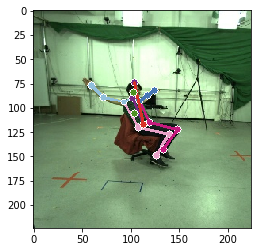

In [19]:
image = original[0].numpy()
kp2d = original[1].numpy()[:, :2]
vis = original[1].numpy()[:, 2]

image = draw_2d_on_image(image, kp2d, vis=vis)
plt.imshow(image)
plt.show()

#### show image with predicted 2d keypoints

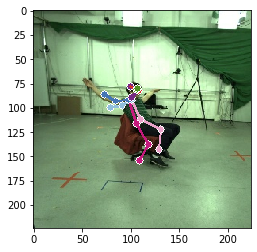

In [20]:
image = original[0].numpy()
kp2d = np.squeeze(result['kp2d'].numpy())
vis = original[1].numpy()[:, 2]
image = draw_2d_on_image(image, kp2d, vis=vis)
plt.imshow(image)
plt.show()

#### show both poses in seperate plots 

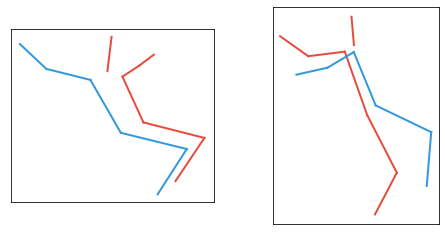

In [21]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

vis = np.expand_dims(original[1].numpy()[:, 2], -1)

#kp2d_real = ((original[1].numpy()[:, :2] + 1) / 2 * image.shape[:2]) * vis
kp2d_real = original[1].numpy() * vis
show_2d_pose(kp2d_real, vis, ax1)

#kp2d_pred = ((np.squeeze(result['kp2d'].numpy()) + 1) / 2 * image.shape[:2]) * vis
kp2d_pred = result['kp2d'].numpy() * vis
show_2d_pose(kp2d_pred, vis, ax2)

<IPython.core.display.Javascript object>


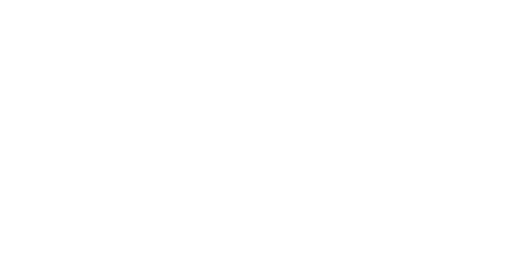

<IPython.core.display.Javascript object>


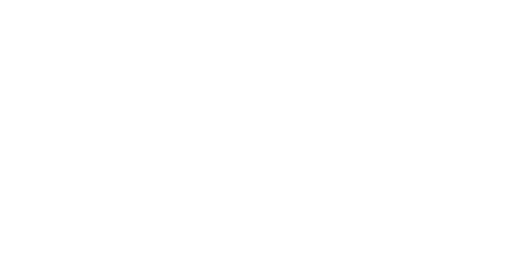

In [22]:
%matplotlib notebook
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# only use predicted camera
camera = np.squeeze(result['cam'].numpy())

# Plot 3d gt
kp3d_real = original[2].numpy()
#kp3d_real = rotate(kp3d_real, camera)
show_3d_pose(kp3d_real, ax1)

# Plot 3d predictions
kp3d_pred = np.squeeze(result['kp3d'].numpy())
kp3d_pred = kp3d_pred[:config.NUM_KP3D, :] # only lsp prediction
#kp3d_pred = rotate(kp3d_pred, camera)
show_3d_pose(kp3d_pred, ax2)

In [23]:
image = original[0].numpy()

vertices = np.squeeze(result['vertices'].numpy())


In [24]:
from trimesh_renderer import TrimeshRenderer
renderer = TrimeshRenderer()

mesh = renderer.mesh(vertices)
mesh.show()

/home/mmc-user/.virtualenvs/hmr2-notebook/lib/python3.6/site-packages/trimesh/scene/scene.py:186: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.graph.nodes:
